In [16]:
import TimeTagger as TT
from TimeTagger import Countrate, Counter

In [2]:
tagger = TT.createTimeTagger()
tagger.reset()
tagger.clearOverflows()


In [3]:
''' set variables and triggers ''' 

# input channels
pmt1_start = -1
pmt1_stop = 1

# trigger levels in V
tagger.setTriggerLevel(pmt1_start,-0.01)  


In [17]:
channels = [pmt1_start,pmt1_stop]

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [ ]:
#Countrate(tagger, channels)
#print(counter.isRunning())
for t in range(100)  :
    if counter.isRunning():
        data = counter.getData()
    else:
        
    ncounts = np.array(counter.getCountsTotal()).sum()
    if ncounts>0: 
        plt.plot(t,data,'.r')
    #print(ncounts,data, end="")
else:
    counter.stop()
    


In [41]:
binwidth*n_values/1E12

1.0

In [43]:
import time

5.0


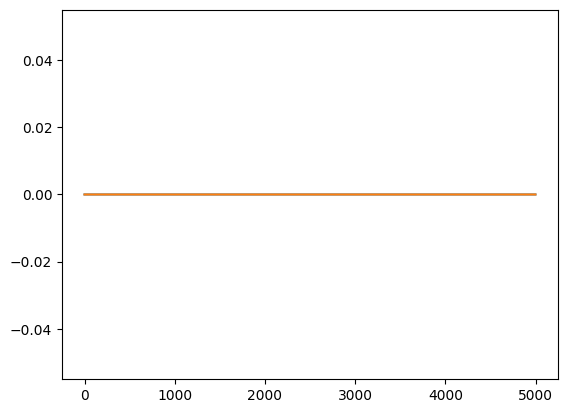

In [45]:
binwidth = 1E9
n_values = 5000
counter = Counter(tagger, channels, binwidth, n_values) 
counter.startFor(capture_duration=binwidth*n_values)
print(binwidth*n_values/1E12,'sec')
while counter.isRunning(): time.sleep(binwidth*n_values/1E12)
if not counter.isRunning():
    data = counter.getData()
    plt. plot(data.T)
    

In [21]:
counter.getConfiguration()

{'name': 'Counter',
 'params': {'binwidth': 1000000000, 'channels': [-1, 1], 'n values': 1000},
 'registered channels': [-1, 1],
 'virtual channels': []}

In [12]:
ncounts,data 

(0, array([nan, nan]))

In [1]:
tagger.stopServer

NameError: name 'tagger' is not defined